In [1]:
from astroquery.vizier import Vizier
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy.signal import correlate
%matplotlib inline

In [2]:
def astro_coord(ra_d, dec_d):
    '''
    convert ICRS ra & dec from data to astropy SkyCoord
    '''
    ra_split = ra_d.split(' ')
    dec_split = dec_d.split(' ')
    
    ra_unit = ['h', 'm', 's']
    dec_unit = ['d', 'm', 's']
    
    ra_hms = ''.join([ra_split[idx]+ra_unit[idx] for idx in range(len(ra_split))])
    dec_dms = ''.join([dec_split[idx]+dec_unit[idx] for idx in range(len(dec_split))])
    
    ra = Angle(ra_hms).to(u.deg)
    dec = Angle(dec_dms).to(u.deg)
    
    coord = SkyCoord(ra, dec, frame='icrs')
    
    return coord

In [3]:
cat = Vizier(catalog='J/AJ/158/77/table2',
            columns=['Source', 'RA_ICRS', 'DE_ICRS', 'GBP-GRP', 'Teff', 'Gmag', 'GMag', 'Prot'])
cat.ROW_LIMIT = -1
data = cat.get_catalogs(cat.catalog)[0].to_pandas()   # downloaded data

In [4]:
data

,Source,RA_ICRS,DE_ICRS,GBP-GRP,Teff,Gmag,GMag,Prot
0,3198972700981234048,04 22 31.5,-07 33 03.2,0.432,7187,8.903,2.802,0.52
1,5181474045115843072,03 10 47.3,-06 34 29.8,0.446,7161,8.562,2.954,0.87
2,2516948215250061568,02 20 22.6,+05 52 59.1,0.597,6622,9.183,3.534,0.82
3,3245408684793798528,04 02 15.4,-05 53 48.2,0.604,6573,9.425,3.513,0.56
4,6628071944405827712,22 36 31.1,-21 35 06.0,0.647,6320,8.967,3.835,0.94
...,...,...,...,...,...,...,...,...
96,5114516020369038848,03 51 15.9,-12 23 46.4,1.732,4298,13.375,7.484,0.68
97,5068272932125221504,02 26 04.6,-29 23 48.9,1.768,4163,12.815,8.000,7.80
98,5094664333632217088,04 02 18.0,-18 42 45.4,1.771,4076,12.631,7.134,2.62
99,5121805541941481472,01 57 17.2,-25 13 49.6,1.784,3956,12.793,7.931,5.45


In [5]:
n_source = len(data)
Coord = []
for i in range(n_source):
    star = data.loc[i]
    source = star['Source']
    
    ra_d = star['RA_ICRS']
    dec_d = star['DE_ICRS']
    
    coord = astro_coord(ra_d, dec_d)
    Coord.append(coord)   # loop through sources and return astropy SkyCoord

In [7]:
sr = lk.search_lightcurve(Coord[0], author="TESS-SPOC")   # check first source on the list

In [8]:
sr

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,TESS-SPOC,1800,37860207,0.0
1,TESS Sector 32,2020,TESS-SPOC,600,37860207,0.0


In [9]:
lc_collection = sr.download_all()   # download lightcurve

In [10]:
lc_collection

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 37860207" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 37860207" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

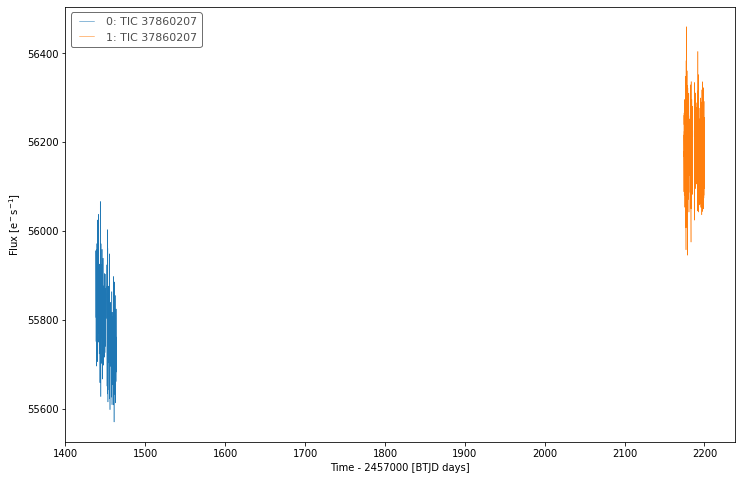

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
lc_collection.plot(ax=ax)   # plot two available lightcurves from source 1

In [12]:
lc_1 = lc_collection[0]
lc_2 = lc_collection[1]   # separate two lightcurves

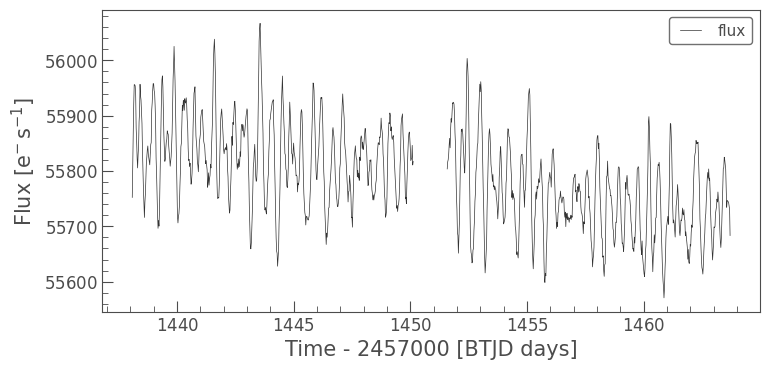

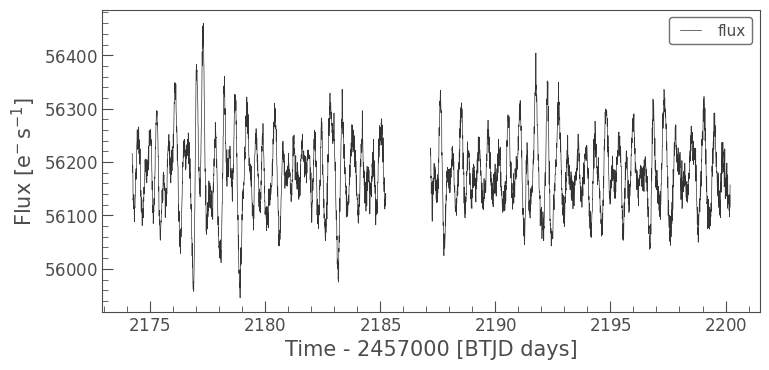

In [13]:
ax1 = lc_1.plot(column='flux', label='flux')
ax2 = lc_2.plot(column='flux', label='flux')   # plot lightcurves individually

Comment from Oli: You can use `view='period'` when calling `plot()` on a periodogram object to view the X-axis in period space! You can also set `scale=log` to see the y-axis information a bit better.

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

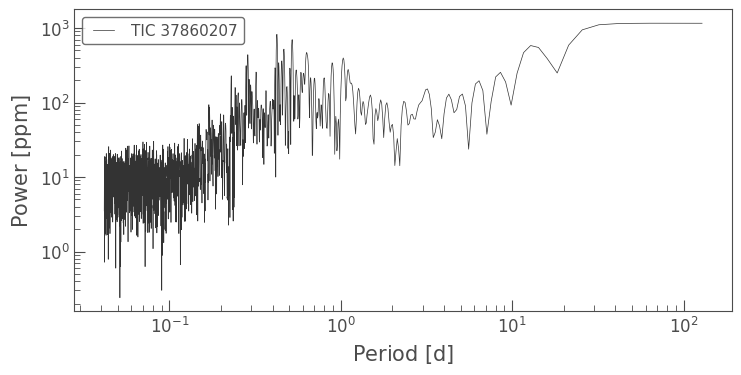

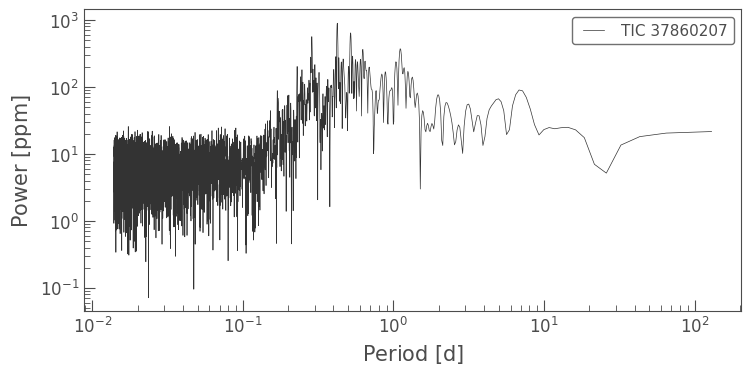

In [18]:
pg1 = lc_1.normalize(unit='ppm').to_periodogram()
pg2 = lc_2.normalize(unit='ppm').to_periodogram()   # obtain periodogram

pg1.plot(view='period', scale='log')
# plt.xlim(0,7)
pg2.plot(view='period', scale='log')
# plt.xlim(0,6)   # plot periodogram

lightkurve.Periodogram properties:
      Attribute         Description   Units
---------------------- -------------- -----
                nterms              1      
              targetid       37860207      
          default_view      frequency      
                 label   TIC 37860207      
             ls_method           fast      
frequency_at_max_power         0.0156 1 / d
             max_power      1161.1236   ppm
               nyquist        24.0002 1 / d
   period_at_max_power        64.0621     d
             frequency  array (3074,) 1 / d
                period  array (3074,)     d
                 power  array (3074,)   ppm
                  meta <class 'dict'>      
p1 is too large, p2 seems more reliable.


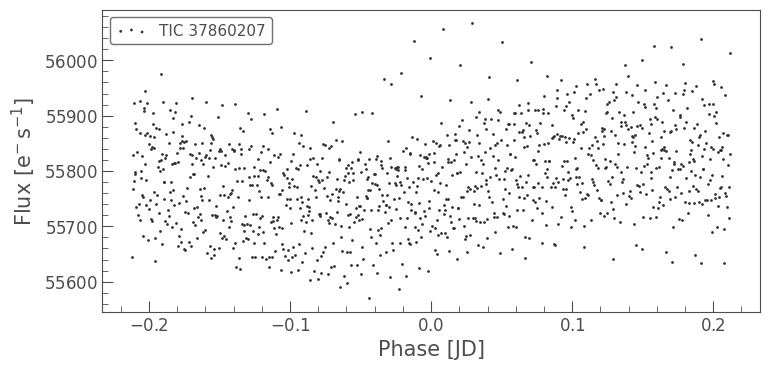

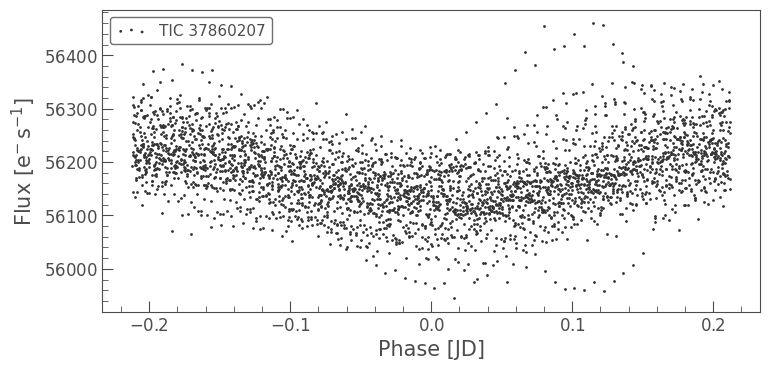

In [16]:
pg1.show_properties()

p1 = pg1.period_at_max_power
p2 = pg2.period_at_max_power   # find period at max power

lc_1.fold(p2).scatter()
lc_2.fold(p2).scatter()   # find out if period at max is the rotation period

print('p1 is too large, p2 seems more reliable.')

There will be many cadences where the flux value is deemed to be wrong, or wasn't measured by the spacecraft at all (for a host of reasons). I think in those cases the Lightkurve objects 

In [25]:
lc_1.meta
q = lc_1.quality == 0

t1 = lc_1.time[q]
f1 = lc_1.flux[q]   # obtain time and flux values

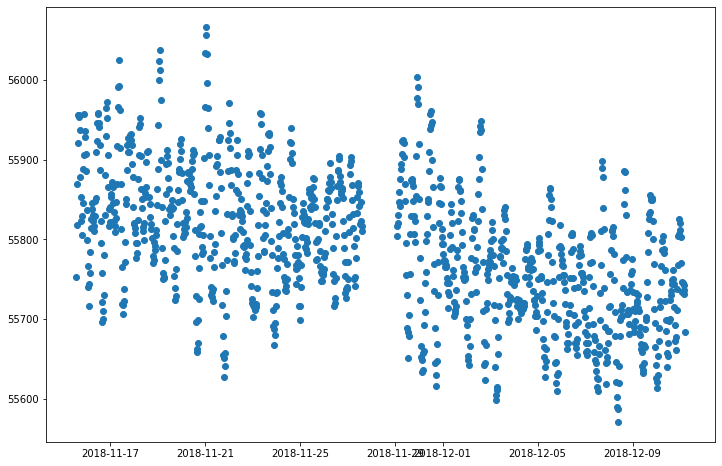

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot_date(t1.plot_date, f1)   # plot lightcurve from t1 and f1 directly

In [29]:
f1_c = correlate(f1, f1)   # try to auto-correlate

x = np.arange(0,len(f1_c),1)   # mock array as x axis for correlation function

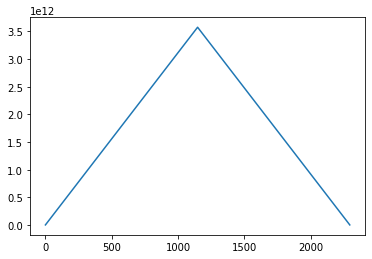

In [30]:
plt.plot(x, f1_c)   # does seem to show any result

In [31]:
f1   # inspect f1

<MaskedQuantity [55752.227, 55817.742, 55869.168, ..., 55736.363,
                 55730.8  , 55683.37 ] electron / s>

In [33]:
t2 = lc_2.time
f2 = lc_2.flux   # check if same happens to the second lightcurve

In [34]:
f2   # inspect f2

<MaskedQuantity [56215.973, 56180.97 , 56186.473, ...,       ———,
                       ———,       ———] electron / s>

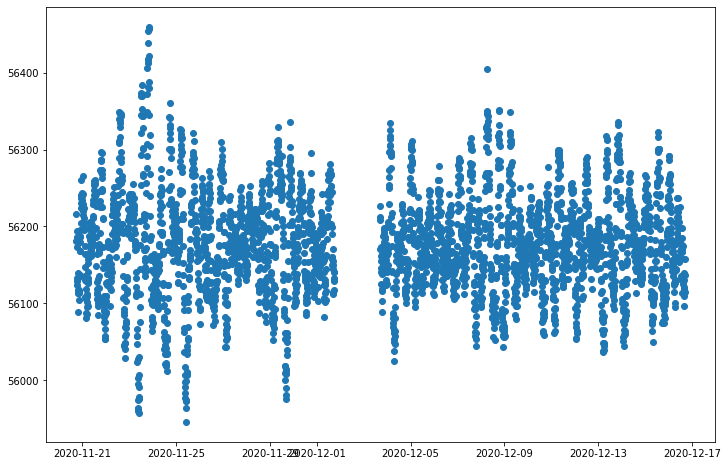

In [35]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot_date(t2.plot_date, f2)   # plot lightcurve directly from t2 and f2

In [36]:
f2_c = correlate(f2, f2)   # find auto-correlation of f2

In [37]:
f2_c   # inspect correlation function

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [38]:
x = np.arange(0,len(f2_c),1)   # mock array for f2 correltion function

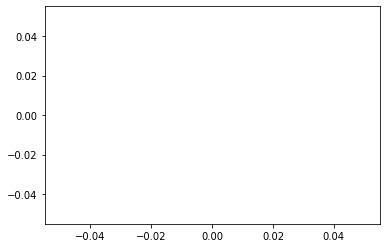

In [39]:
plt.plot(x, f2_c)   # try to plot correlation function

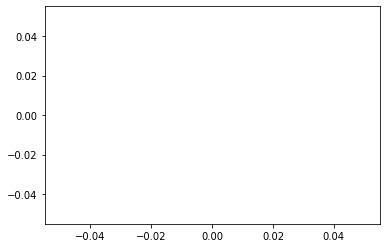

In [40]:
ex = f2[-1]
f2_m = f2[f2!=ex]
f2_cm = correlate(f2_m, f2_m)   # try to get rid of nan values in f2 and auto-correlate

x = np.arange(0,len(f2_cm),1)
plt.plot(x, f2_cm)   # plot correlation function

In [41]:
sr = lk.search_lightcurve(Coord[1], author="TESS-SPOC")   # check second source on the list

lc_collection = sr.download_all()   # download lightcurve



In [42]:
lc_collection

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 9805084" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 9805084" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [43]:
lc_1 = lc_collection[0]
lc_2 = lc_collection[1]   # separate two lightcurve

t1 = lc_1.time
f1 = lc_1.flux   # obtain time and flux values

In [44]:
f1

<MaskedQuantity [76190.836, 76106.24 , 76082.26 , ...,       ———,
                       ———,       ———] electron / s>

In [45]:
t2 = lc_2.time
f2 = lc_2.flux   # obtain time and flux values

In [46]:
f2

<MaskedQuantity [76155.71 , 76167.48 , 76169.77 , ..., 76149.33 ,
                 76114.766, 76096.4  ] electron / s>

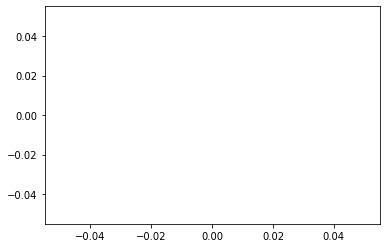

In [47]:
f2_c = correlate(f2, f2)
x = np.arange(0,len(f2_c),1)

plt.plot(x, f2_c)   # plot correlation function

In [109]:
F2 = []
for i in f2:
    f2_v = float(i.value)
    F2.append(f2_v)

In [133]:
F2_C = correlate(F2[:1600], F2[:1600])

F2_C

array([5.81574569e+09, 1.16304640e+10, 1.74452164e+10, ...,
       1.74452164e+10, 1.16304640e+10, 5.81574569e+09])

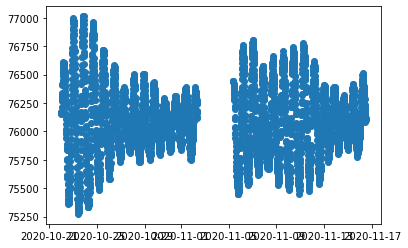

In [130]:
plt.plot_date(t2.plot_date, f2)   # plot lightcurve directly from t2 and f2

In [114]:
a = [1,2,3]
b = [2,3,4]

c = correlate(a, b)

In [115]:
c

array([ 4, 11, 20, 13,  6])